In [242]:
#@title All `dm_control` imports required for this tutorial
%env MUJOCO_GL=egl
# The basic mujoco wrapper.
from dm_control import mujoco

# PyMJCF
from dm_control import mjcf
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib


# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.


# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)


env: MUJOCO_GL=egl


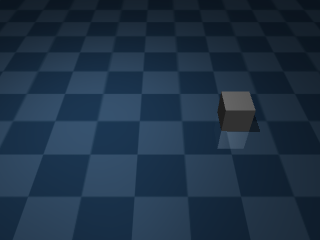

In [186]:
working_model = """
<mujoco model="thrown_ball">
  <visual>
    <global offwidth="640" offheight="480"/>
  </visual>
  <option integrator="RK4"/>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3" 
     rgb2=".2 .3 .4" width="300" height="300"/>
    <material name="grid" texture="grid" texrepeat="8 8" reflectance=".1"/>
  </asset>
  <worldbody>
    <geom size=".5 .5 .01" type="plane" material="grid" friction="0.01"/>
    <light pos="0 0 .6"/>
    <body name="ball" pos="0.2 0 .02">
      <freejoint/>
      <geom name="ball" type="box" size=".02 .02 .02" solref="-100000 -100" friction="0"/>
    </body>
  </worldbody>
  <keyframe>
    <key name="spinning" qpos="0.2 0 0.1 1 0 0 0" qvel="-0.2 0 1 0 0 0" />
  </keyframe>
</mujoco>
"""
physics = mujoco.Physics.from_xml_string(working_model)
PIL.Image.fromarray(physics.render())

In [321]:
# Model element from MJCF

model = mjcf.RootElement()
model.visual.__getattr__('global').offwidth = "640"
model.visual.__getattr__('global').offheight = "480"
model.option.integrator = "RK4"
body = model.worldbody.add('body', name = "ballbody")
body.add('freejoint')
body.add('geom', type='box', name='ball', pos = [0.2,0,0.02], size="0.02 0.02 0.02", rgba=[1,0,0,1],
solref="-100000 -100", friction="0")
chequered = model.asset.add('texture', type='2d', builtin='checker', width=300,
                            height=300, rgb1=[.1, .2, .3], rgb2=[.2, .3, .4])
grid = model.asset.add('material', name='grid', texture=chequered,
                       texrepeat=[8, 8], reflectance=0)
model.worldbody.add('geom', name = "floor", type='plane', size="2 2 .01", material=grid, friction="0.01")
model.worldbody.add('light', pos=[0, 0, 2])
model.worldbody.add('camera', name="custom_cam", pos="0 -0.5 0.1", euler=[85, 0, 0])
model.keyframe.add('key', name="throw", time= "0", qpos="0.1 0 0.1 1 0 0 0", qvel="-0.2 0 1 0 0 0")
# print(model.to_xml_string())

MJCF Element: <key name="throw" time="0" qpos="0.10000000000000001 0 0.10000000000000001 1 0 0 0" qvel="-0.20000000000000001 0 1 0 0 0"/>

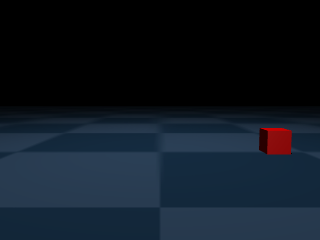

In [322]:
physics = mjcf.Physics.from_mjcf_model(model)

scene_option = mujoco.wrapper.core.MjvOption()
scene_option.frame = enums.mjtFrame.mjFRAME_GEOM
scene_option.flags[enums.mjtVisFlag.mjVIS_TRANSPARENT] = True

PIL.Image.fromarray(physics.render(camera_id='custom_cam'))

In [323]:
duration = 4    # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
physics.reset(0)  # Reset to keyframe 0 (load a saved state).
while physics.data.time < duration:
  physics.step()
  if len(frames) < (physics.data.time) * framerate:
    pixels = physics.render(camera_id='custom_cam')
    frames.append(pixels)

display_video(frames, framerate)

In [320]:
mjcf_model = mjcf.from_xml_string(working_model)

In [124]:
mjcf_model.all_children()

[MJCF Element: <compiler/>,
 MJCF Element: <option integrator="RK4"/>,
 MJCF Element: <size/>,
 MJCF Element: <visual>...</visual>,
 MJCF Element: <statistic/>,
 MJCF Element: <default>...</default>,
 MJCF Element: <extension/>,
 MJCF Element: <custom/>,
 MJCF Element: <asset>...</asset>,
 MJCF Element: <worldbody>...</worldbody>,
 MJCF Element: <contact/>,
 MJCF Element: <equality/>,
 MJCF Element: <tendon/>,
 MJCF Element: <actuator/>,
 MJCF Element: <sensor/>,
 MJCF Element: <keyframe>...</keyframe>]

In [223]:
new_physics = mjcf.Physics.from_mjcf_model(model)
new_camera = mujoco.Camera(new_physics)
# old_physics = mujoco.Physics.from_xml_string(working_model)
# old_camera = mujoco.Camera(old_physics)

In [200]:
dir(model.default.camera)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_alias_attributes_dict',
 '_attach',
 '_attach_children',
 '_attachments',
 '_attributes',
 '_attributes_to_xml',
 '_cached_full_identifier',
 '_cached_namescope',
 '_cached_revision',
 '_cached_root',
 '_check_attachments_on_remove',
 '_check_conflicting_attributes',
 '_check_valid_attachment',
 '_check_valid_attribute',
 '_check_valid_child',
 '_children',
 '_children_to_xml',
 '_default_identifier',
 '_detach',
 '_get_attribute',
 '_has_same_children_as',
 '_init_stack',
 '_is_removed',
 '_is_worldbody',
 '_last_attribute_error',
 '_own_attributes',
 '_parent',
 '

In [214]:
old_model = mjcf.from_xml_string(working_model)

In [201]:
model.default.camera.to_xml_string()

'<camera/>\n'

In [181]:
new_camera.matrices = old_camera.matrices

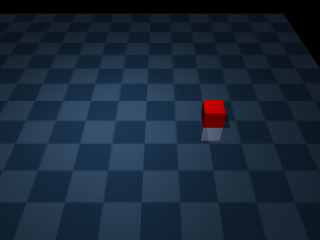

In [224]:
PIL.Image.fromarray(new_camera.render().astype(np.uint8))

In [192]:
new_camera.matrices()[3]

array([[ 1.        ,  0.        ,  0.        , -0.09232051],
       [ 0.        ,  1.        ,  0.        ,  0.4263801 ],
       [ 0.        ,  0.        ,  1.        , -0.42870063],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [193]:
old_camera.matrices()[3]

array([[ 1.        ,  0.        ,  0.        , -0.09232051],
       [ 0.        ,  1.        ,  0.        ,  0.30190739],
       [ 0.        ,  0.        ,  1.        , -0.30422789],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [204]:
new_physics = mjcf.Physics.from_mjcf_model(model)
new_camera = mujoco.Camera(new_physics)


['_ACTUATOR_TAGS',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'commit_defaults',
 'get_attachment_frame',
 'get_frame_freejoint',
 'get_frame_joints',
 'get_freejoint']

In [326]:
os.environ["MUJOCO_GL"]

'egl'